In [1]:
#!pip install beautifulsoup4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import time
import copy
from sklearn.datasets import make_classification
from alipy import ToolBox
from bs4 import BeautifulSoup
import re

In [3]:
# Check Gpu
tf.test.gpu_device_name()

2022-03-09 09:59:46.920988: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-09 09:59:47.959340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 46900 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-03-09 09:59:47.960013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 46900 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:d8:00.0, compute capability: 7.5


'/device:GPU:0'

In [4]:
# Import the Dataset
df = pd.read_csv('data/IMDB Dataset.csv', nrows=7000)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
6995,I rented this obscure aussie relic a few years...,positive
6996,Okay - I'll confess. This is the movie that ma...,positive
6997,I'm probably one of the biggest Nancy Drew fan...,positive
6998,The movie began well enough. It had a fellow g...,negative


In [5]:
print(df.shape)

(7000, 2)


In [6]:
# Limit dataframe to work faster
#df = df[:500]
df['review']

0       One of the other reviewers has mentioned that ...
1       A wonderful little production. <br /><br />The...
2       I thought this was a wonderful way to spend ti...
3       Basically there's a family where a little boy ...
4       Petter Mattei's "Love in the Time of Money" is...
                              ...                        
6995    I rented this obscure aussie relic a few years...
6996    Okay - I'll confess. This is the movie that ma...
6997    I'm probably one of the biggest Nancy Drew fan...
6998    The movie began well enough. It had a fellow g...
6999    I watched the Unrated version of this film and...
Name: review, Length: 7000, dtype: object

In [7]:
df.dropna()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
6995,I rented this obscure aussie relic a few years...,positive
6996,Okay - I'll confess. This is the movie that ma...,positive
6997,I'm probably one of the biggest Nancy Drew fan...,positive
6998,The movie began well enough. It had a fellow g...,negative


In [8]:
# Change positive and negative to 1 and 0
df['sentiment'] = np.where((df.sentiment == 'positive'),1,df.sentiment)
df['sentiment'] = np.where((df.sentiment == 'negative'),0,df.sentiment)
df['sentiment']

0       1
1       1
2       1
3       0
4       1
       ..
6995    1
6996    1
6997    1
6998    0
6999    0
Name: sentiment, Length: 7000, dtype: object

In [9]:
#df['sentiment'] = df.astype(int)
df['sentiment'].value_counts()

0    3505
1    3495
Name: sentiment, dtype: int64

In [10]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    return text

#Apply function on review column
df['review']=df['review'].apply(denoise_text)


df.describe()

df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
6995,I rented this obscure aussie relic a few years...,1
6996,Okay Ill confess This is the movie that made ...,1
6997,Im probably one of the biggest Nancy Drew fans...,1
6998,The movie began well enough It had a fellow ge...,0


In [11]:
df['review']

0       One of the other reviewers has mentioned that ...
1       A wonderful little production The filming tech...
2       I thought this was a wonderful way to spend ti...
3       Basically theres a family where a little boy J...
4       Petter Matteis Love in the Time of Money is a ...
                              ...                        
6995    I rented this obscure aussie relic a few years...
6996    Okay  Ill confess This is the movie that made ...
6997    Im probably one of the biggest Nancy Drew fans...
6998    The movie began well enough It had a fellow ge...
6999    I watched the Unrated version of this film and...
Name: review, Length: 7000, dtype: object

In [12]:
df['sentiment'] = df['sentiment'].astype(int)

In [13]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
6995,I rented this obscure aussie relic a few years...,1
6996,Okay Ill confess This is the movie that made ...,1
6997,Im probably one of the biggest Nancy Drew fans...,1
6998,The movie began well enough It had a fellow ge...,0


In [14]:
# Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

# Create Bert tokenizer class
tokenizer_class = ppb.BertTokenizer

# Save the weights for uncased Bert 
pretrained_weights = 'bert-base-cased'

# Create a tokenizer from tokenizer class
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

# Tokenize all of the sentences 
tokenized = df['review'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)))

In [15]:
len(tokenized[0])

340

In [16]:
tokenized.shape

(7000,)

In [17]:
# Add padding to all of the sentences so that they have the same size
# So the input can be represented as a 2d array
# Important for performance

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

padded

array([[ 101, 1448, 1104, ...,    0,    0,    0],
       [ 101,  138, 7310, ...,    0,    0,    0],
       [ 101,  146, 1354, ...,    0,    0,    0],
       ...,
       [ 101,  146, 1306, ...,    0,    0,    0],
       [ 101, 1109, 2523, ...,    0,    0,    0],
       [ 101,  146, 2542, ...,    0,    0,    0]])

In [18]:
np.array(padded).shape

(7000, 512)

In [19]:
# Attention mask is created to mask the padded values
attention_mask = np.where(padded != 0, 1, 0)
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [20]:
attention_mask.shape

(7000, 512)

In [21]:
# For DistilBERT:

# Create config just in case 
config = ppb.BertConfig(output_hidden_states=True)
model_class = ppb.BertModel(config=config)

# Load pretrained model/tokenizer
model = model_class.from_pretrained(pretrained_weights)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
# Check model config 
model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [23]:
# Transform padded to a tensor 
input_ids = torch.tensor(padded)  

# Transfer mask to a tensor 
attention_mask = torch.tensor(attention_mask)

# Run the sentences through BERT save the states of each layer to hidden_states
with torch.no_grad():    
    outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)

In [24]:
len(outputs)

3

In [25]:
#outputs[2] gets all of the 12 layers

hidden_states = outputs[2]

In [26]:
len(hidden_states)

13

In [27]:
embedding_output = hidden_states[0]

layer_1 = hidden_states[1]
layer_2 = hidden_states[2]
layer_3 = hidden_states[3]
layer_4 = hidden_states[4]
layer_5 = hidden_states[5]
layer_6 = hidden_states[6]
layer_7 = hidden_states[7]
layer_8 = hidden_states[8]
layer_9 = hidden_states[9]
layer_10 = hidden_states[10]
layer_11 = hidden_states[11]
layer_12 = hidden_states[12]

In [28]:
layer_12.shape

torch.Size([7000, 512, 768])

In [29]:
# Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. 
# The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. 
# The output corresponding to that token can be thought of as an embedding for the entire sentence.
# We'll save those in the features variable, as they'll serve as the features to our random forest classifier.

features_1 = layer_1[:,0,:].numpy()
features_2 = layer_2[:,0,:].numpy()
features_3 = layer_3[:,0,:].numpy()
features_4 = layer_4[:,0,:].numpy()
features_5 = layer_5[:,0,:].numpy()
features_6 = layer_6[:,0,:].numpy()
features_7 = layer_7[:,0,:].numpy()
features_8 = layer_8[:,0,:].numpy()
features_9 = layer_9[:,0,:].numpy()
features_10 = layer_10[:,0,:].numpy()
features_11 = layer_11[:,0,:].numpy()
features_12 = layer_12[:,0,:].numpy()

labels = df['sentiment']
labels_np = labels.to_numpy()

labels_np.shape

(7000,)

In [30]:
#Do active learning with y_confidence values but how?

#!pip install alipy

total_time = []

In [31]:
# Define active learning loop using ALiPy
# Check http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/huangsj/alipy/example.html#collapseOne

def main_loop(alibox, strategy, round):
        # Get the data split of one fold experiment
        train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)
        # Get intermediate results saver for one fold experiment
        saver = alibox.get_stateio(round, saving_path=f"./{strategy.__class__.__name__}_{round}.pkl")

        # Set initial performance point
        model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
        pred = model.predict(X[test_idx, :])
        accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                  y_pred=pred,
                                                  performance_metric='accuracy_score')
        saver.set_initial_point(accuracy)

        # If the stopping criterion is simple, such as query 50 times. Use `for i in range(50):` is ok.
        while not stopping_criterion.is_stop():
            # Select a subset of Uind according to the query strategy
            # Passing model=None to use the default model for evaluating the committees' disagreement
            # Set batch size 2
            select_ind = strategy.select(label_index=label_ind, unlabel_index=unlab_ind, batch_size=32, model=model)
            label_ind.update(select_ind)
            unlab_ind.difference_update(select_ind)
            
            
            start = time.time()
            # Update model and calc performance according to the model you are using
            model.fit(X=X[label_ind.index, :], y=y[label_ind.index])
            end = time.time()
            
            iteration_time = end-start
            total_time.append(iteration_time)
            
            pred = model.predict(X[test_idx, :])
            accuracy = alibox.calc_performance_metric(y_true=y[test_idx],
                                                      y_pred=pred,
                                                      performance_metric='accuracy_score')

            # Save intermediate results to file
            st = alibox.State(select_index=select_ind, performance=accuracy)
            saver.add_state(st)
            saver.save()

            # Passing the current progress to stopping criterion object
            stopping_criterion.update_information(saver)
        # Reset the progress in stopping criterion object
        stopping_criterion.reset()
        return saver

In [32]:
# Define some stuff for AL loop

n_iteration = 1200 


In [33]:
# Create holders for uncertantiy sampling results for each different layer

unc_result_1 = []
unc_result_2 = []
unc_result_3 = []
unc_result_4 = []
unc_result_5 = []
unc_result_6 = []
unc_result_7 = []
unc_result_8 = []
unc_result_9 = []
unc_result_10 = []
unc_result_11 = []
unc_result_12 = []

unc_result_add_last_4 = []
unc_result_cct_last_4 = []


unc_results = (unc_result_1, unc_result_2, unc_result_3, unc_result_4, unc_result_5, unc_result_6,
                unc_result_7, unc_result_8, unc_result_9, unc_result_10, unc_result_11, unc_result_12,
                unc_result_add_last_4, unc_result_cct_last_4)

In [34]:
# Save the CLS values in a list to iterate them on the model
CLS_layers = ()

In [35]:
# get layer combinations for addition

add_5_6 = np.add(features_5, features_6)
add_7_8 = np.add(features_7, features_8)
add_9_10 = np.add(features_9, features_10)
add_11_12 = np.add(features_11, features_12)


add_9_12 = np.add(add_9_10, add_11_12)

add_7_10 = np.add(add_7_8, add_9_10)

add_5_8 = np.add(add_5_6, add_7_8)



In [36]:
CLS_layers = (features_1, features_2, features_3, features_4, features_5, features_6, features_7,
                features_8, features_9, features_10, features_11, features_12, add_7_10, add_9_12)

In [37]:
for i in range(len(CLS_layers)):

    X=CLS_layers[i]
    y=labels_np

    alibox = ToolBox(X=X, y=y, query_type='AllLabels', saving_path='.')

    # Split data
    alibox.split_AL(test_ratio=0.3, initial_label_rate=0.1, split_count=10)

    # Use the default Logistic Regression classifier
    model = alibox.get_default_model()

    # The cost budget is 50 times querying
    stopping_criterion = alibox.get_stopping_criterion('num_of_queries', n_iteration)
    

    for round in range(5):
        train_idx, test_idx, label_ind, unlab_ind = alibox.get_split(round)

        # Use pre-defined strategy
        unc = alibox.get_query_strategy(strategy_name="QueryInstanceUncertainty")

        unc_results[i].append(copy.deepcopy(main_loop(alibox, unc, round)))
        


| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   490 (10.00% of all)  |        138        |  0   | 0.733 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: |
|   1   |   490 (10.00% of all)  |        138        |  0   | 0.742 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   2   |   490 (10.00% of all)  |        138        |  0   | 0.731 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   3   |   490 (10.00% of all)  |        138        |  0   | 0.730 ± 0.01 |
| round | initially labeled data | number of queries | cost | Performance: |
|   4   |   490 (10.00% of all)  |        138        |  0   | 0.746 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: |
|   0   |   490 (10.00% of all)  |        138        |  0   | 0.776 ± 0.02 |
| round | initially labeled data | number of queries | cost | Performance: 


+----------------+-------------------+---------------------------+--------------+------------+
|    Methods     | number_of_queries | number_of_different_split | performance  | batch_size |
+----------------+-------------------+---------------------------+--------------+------------+
|  Unc_Layer_12  |        138        |             5             | 0.807 ± 0.00 |     32     |
|  Unc_Layer_11  |        138        |             5             | 0.788 ± 0.01 |     32     |
|  Unc_Layer_10  |        138        |             5             | 0.780 ± 0.01 |     32     |
|  Unc_Layer_9   |        138        |             5             | 0.795 ± 0.00 |     32     |
|  Unc_Layer_8   |        138        |             5             | 0.795 ± 0.01 |     32     |
|  Unc_Layer_7   |        138        |             5             | 0.803 ± 0.00 |     32     |
|  Unc_Layer_6   |        138        |             5             | 0.811 ± 0.00 |     32     |
|  Unc_Layer_5   |        138        |           

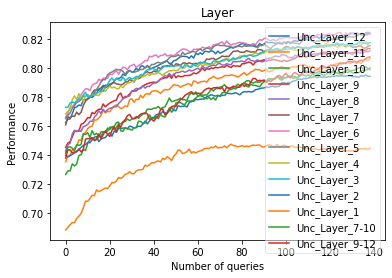

In [41]:
analyser = alibox.get_experiment_analyser(x_axis='num_of_queries')


for i in range(len(unc_results)-2):
    
    # Iterationg results in reverse beacues 12th layer has the best performance and will stay at top
    # On the plot we want to somehow corralete the layer and the plot
    analyser.add_method(method_name='Unc_Layer_' + str(len(CLS_layers)-i-2), method_results=unc_results[len(CLS_layers)-i-3])        
    
analyser.add_method(method_name='Unc_Layer_7-10' , method_results=unc_results[12])
analyser.add_method(method_name='Unc_Layer_9-12' , method_results=unc_results[13])
    
print(analyser)
analyser.plot_learning_curves(title='Layer', std_area=False)

In [39]:

avg_time = sum(total_time) / len(total_time)
    
print('FOR 14 TRANSFORMER BLOCKS' )
print('1200 Queries')
print('5 different train/test splits')
print("-----------------------------------------")
print("Average Runtime For one Transformer Block")
print(avg_time)
               
print("Maximum Runtime For one Query")
print(max(total_time))
               
print("Minimum Runtime For one Query")
print(min(total_time))

print("Total Time")
print(sum(total_time))

FOR 14 TRANSFORMER BLOCKS
1200 Queries
5 different train/test splits
-----------------------------------------
Average Runtime For one Transformer Block
0.925845854376167
Maximum Runtime For one Query
5.127974510192871
Minimum Runtime For one Query
0.027325153350830078
Total Time
8943.670953273773


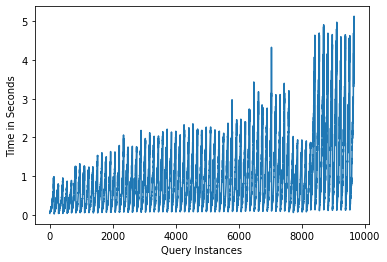

In [40]:
import matplotlib.pyplot as plt

plt.plot(total_time)
plt.ylabel('Time in Seconds')
plt.xlabel('Query Instances')
plt.show()